In [28]:
import os
from collections import defaultdict as dd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt

# read data

In [66]:
mats = {}
totals = {}

with os.scandir("./data/2022-07/labeled_sanitized/") as directory:
    for entry in directory:
        if entry.is_file() and int(entry.name[4:entry.name.index(".txt")]) in (1,2,3,4,5,6):
            print(f"reading {entry.name}...")
            with open(entry.path) as file:
                for i, line in enumerate(file.readlines()):
                    if i > 15:
                        idx = i % 7
                        if idx == 3:
                            id_l = line[1:line.index(')')]
                        elif idx == 4:
                            id_r = line[1:line.index(')')]
                        elif idx == 5:
                            if line == 'Y\n':
                                label = 0  # pairwise neutrality
                            elif line == 'N\n':
                                label = 1
                            elif line == 'M\n':
                                label = 0.5
                            else:
                                raise ValueError(f"invalid label: '{line}'")
                            pair = (int(id_l[1:]), int(id_r[1:]))
                            source = id_l[0]
                            if source not in mats:
                                mats[source] = dd(int)
                                totals[source] = dd(int)
                            mats[source][pair] += label
                            totals[source][pair] += 1

for source in mats:
    mat = mats[source]
    tot = totals[source]
    for key in mat:
        mat[key] /= tot[key]

reading set_1.txt...
reading set_2.txt...
reading set_3.txt...
reading set_4.txt...
reading set_5.txt...
reading set_6.txt...


# generate graphs

## real data

In [67]:
for source in mats:
    with open(f"./data/graphs/{source}.txt", "w") as file:
        res = []
        for (u,v), weight in mats[source].items():
            res.append(f"{u} {v} {weight}")
        file.write('\n'.join(res))

## semi-synthetic data

In [68]:
wlist = []
for mat in mats.values():
    for val in mat.values():
        wlist.append(val)

In [69]:
counts = dd(int)
for w in wlist:
    counts[w] += 1
counts_x = sorted(counts.keys())
counts_y = []
for x in counts_x:
    counts_y.append((counts_y[-1] if counts_y else 0) + counts[x] / len(wlist))

In [70]:
distributions = [st.alpha, st.anglit, st.arcsine, st.argus, st.beta, st.betaprime, st.bradford, st.burr, st.burr12, st.cauchy, st.chi, st.chi2, st.cosine, st.crystalball, st.dgamma, st.dweibull, st.exponnorm, st.exponweib, st.exponpow, st.f, st.fatiguelife, st.fisk, st.foldcauchy, st.foldnorm, st.genlogistic, st.gennorm, st.genpareto, st.genexpon, st.genextreme, st.gausshyper, st.gamma, st.gengamma, st.genhalflogistic, st.genhyperbolic, st.geninvgauss, st.gompertz, st.gumbel_r, st.gumbel_l, st.halfcauchy, st.halflogistic, st.halfnorm, st.halfgennorm, st.hypsecant, st.invgamma, st.invgauss, st.invweibull, st.johnsonsb, st.johnsonsu, st.kappa4, st.kappa3, st.ksone, st.kstwobign, st.laplace, st.laplace_asymmetric, st.levy, st.levy_l, st.logistic, st.loggamma, st.lognorm, st.loguniform, st.lomax, st.maxwell, st.mielke, st.moyal, st.nakagami, st.ncx2, st.ncf, st.nct, st.norm, st.norminvgauss, st.pareto, st.pearson3, st.powerlaw, st.powerlognorm, st.powernorm, st.rdist, st.rayleigh, st.rice, st.recipinvgauss, st.semicircular, st.skewcauchy, st.skewnorm, st.t, st.trapezoid, st.triang, st.truncexpon, st.truncnorm, st.vonmises_line, st.wald, st.weibull_min, st.weibull_max, st.wrapcauchy]

In [71]:
mles = []
for dist in distributions:
    print(dist.name, end=", ")
    params = dist.fit(wlist)
    mle = dist.nnlf(params, wlist)
    mles.append(mle)

best_fits = sorted( [(dist.name, mle) for dist, mle in zip(distributions, mles)], key=lambda x: x[1] )

alpha, anglit, 

/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


arcsine, argus, beta, betaprime, bradford, burr, 

/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:809: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:813: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:950: RuntimeWarning: overflow encountered in power
  - sc.xlog1py(d_+1, x_**(-c_))))


burr12, cauchy, chi, chi2, cosine, crystalball, dgamma, dweibull, exponnorm, exponweib, exponpow, f, fatiguelife, fisk, foldcauchy, foldnorm, genlogistic, gennorm, genpareto, genexpon, genextreme, 

/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


gausshyper, gamma, 

/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:3622: RuntimeWarning: divide by zero encountered in power
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c


gengamma, genhalflogistic, 

/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2959: RuntimeWarning: divide by zero encountered in power
  tmp0 = tmp**(limit-1)
/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2960: RuntimeWarning: invalid value encountered in multiply
  tmp2 = tmp0*tmp


genhyperbolic, geninvgauss, 

/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:3857: RuntimeWarning: Infinite values encountered in scipy.special.kve(p, b). Values replaced by NaN to avoid incorrect results.
  warnings.warn(msg, RuntimeWarning)


gompertz, gumbel_r, gumbel_l, halfcauchy, halflogistic, halfnorm, halfgennorm, hypsecant, invgamma, invgauss, invweibull, johnsonsb, johnsonsu, 

/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:4343: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))
/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1867: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


kappa4, kappa3, ksone, 

/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:106: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


kstwobign, laplace, laplace_asymmetric, levy, levy_l, logistic, loggamma, lognorm, loguniform, lomax, maxwell, mielke, moyal, nakagami, ncx2, ncf, nct, 

/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6432: RuntimeWarning: overflow encountered in exp
  Px = np.exp(trm1)
/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6438: RuntimeWarning: invalid value encountered in multiply
  Px *= trm1+trm2
/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6435: RuntimeWarning: overflow encountered in multiply
  / np.asarray(fac1*sc.gamma((n+1)/2)))
/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6437: RuntimeWarning: overflow encountered in multiply
  / np.asarray(np.sqrt(fac1)*sc.gamma(n/2+1)))


norm, norminvgauss, pareto, pearson3, powerlaw, powerlognorm, powernorm, rdist, rayleigh, rice, recipinvgauss, semicircular, skewcauchy, skewnorm, t, trapezoid, triang, truncexpon, truncnorm, 

/home/rishi/mambaforge/envs/news-ordering/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7815: RuntimeWarning: divide by zero encountered in log1p
  logdelta = sla + np.log1p(-np.exp(slb - sla))


vonmises_line, wald, weibull_min, weibull_max, wrapcauchy, 

In [72]:
print("-- lower number is better --")
for name, fit in best_fits[:8]:
    print(f"{name}: {fit}")
print("...")
for name, fit in best_fits[-8:]:
    print(f"{name}: {fit}")

-- lower number is better --
johnsonsb: -788.8224019332233
weibull_max: -783.8499424631261
arcsine: -554.1155896370966
pearson3: -465.0150256302349
gausshyper: -310.1328895994256
genpareto: -289.513947229831
johnsonsu: -249.39223132530424
genextreme: -231.31606090366463
...
f: 82.22542527448853
halfcauchy: 84.7685005886847
ncf: 93.62235628892348
levy: 124.5346489725158
anglit: inf
loguniform: inf
rdist: inf
truncnorm: inf


In [73]:
func = st.beta

In [74]:
params = func.fit(wlist)

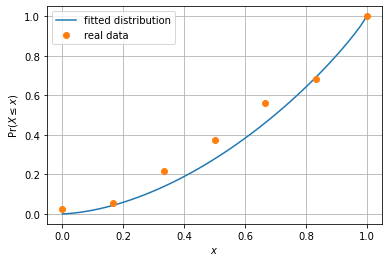

In [80]:
fig, ax = plt.subplots()
# fig.suptitle('CDF for real data and fitted distribution')

domain = np.linspace(0, 1, num=50)
ax.plot(domain, [func.cdf(x, *params) for x in domain], label='fitted distribution')

ax.plot(counts_x, counts_y, 'o', label='real data')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\Pr(X \leq x)$')

ax.legend()
ax.grid(visible=True)

plt.savefig("plots/distribution_fitting.pdf")

In [76]:
print(f"The best non-pathological fit is the `{func.name}` distribution with parameters {params}.")

The best non-pathological fit is the `beta` distribution with parameters (1.7187517116068227, 0.9004059519892909, -0.010075465525660627, 1.0100754655256607).


#### random weight function for generating graphs

In [77]:
# 2022-02 DATASET
# def random_weight():
#     # parameters for distribution computed in `labels_to_graph.ipynb`
#     sample = st.triang.rvs(0.9999995032790814, -0.38730256734947843, 1.3873032751477359)
#     return min(1, max(0, sample))

In [81]:
# 2022-07 DATASET
# def random_weight():
#     # parameters for distribution computed in `labels_to_graph.ipynb`
#     sample = st.beta.rvs(1.7187517116068227, 0.9004059519892909, -0.010075465525660627, 1.0100754655256607) # USA + Paolo
#     sample = st.beta.rvs(2.136491095517801, 0.5465119579191644, -0.061758139675320074, 1.0617581396753204) # USA
#     sample = st.beta.rvs(2.111725661571607, 0.6292620622053352, -0.25550988538252306, 1.2555098853825233) # EU
#     sample = st.beta.rvs(2.6742109756662966, 0.6367712741345288, 0.06362872538929235, 0.9363712746107078) # all
#     return min(1, max(0, sample))